## Train pointwise ML model using first order gradients

Taking inspiration from LES gradient models we train a ML model using the first order gradients of velocity and slopes as input. The output will be the streamfunction. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

In [4]:
kind = 'MITgcm'
MITgcm_bucket ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

L = '100'
Lint = int(L)
fname = f'{MITgcm_bucket}/ML_data/ds_ML_'+L+'km_3D'

In [5]:
ML_data = datasets.MITgcm_transformer(fname, Lint, 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])
ML_data.convert_subsampled_normed();
ML_data.generate_test_train_batches();

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Loaded from saved norm nc
Normalized data
loading
stacking, droping nans, randomizing
Test and train batches split. Number of batches: 37-5


In [6]:
ANN_model = ML_classes.ANN(num_in = len(ML_data.input_channels))
regress_sys = ML_classes.RegressionSystem(ANN_model)

In [ ]:
%%time
regress_sys.train_system(ML_data, 201)

Train loss step 0:  0.5528765779894751 test loss: 0.28171310424804685


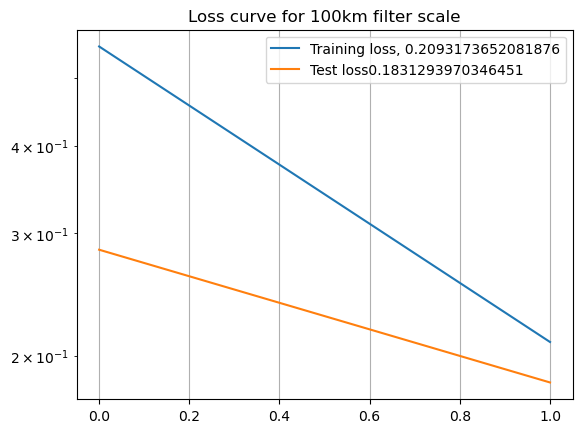

In [10]:
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.title('Loss curve for '+ L+ 'km filter scale')
plt.grid()
plt.yscale('log')
plt.legend()

plt.savefig('figures/MITgcm_'+Lsel+'km_loss_curve.png')

In [11]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/checkpoints/ckpts_'+L+'_test_new'#+'_'+str(bias)
regress_sys.save_checkpoint(CKPT_DIR)

In [79]:
# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/model_ncs/'
regress_sys.save_weights_nc(model_nc + 'test.nc')

In [77]:
regress_sys.input_channels

['U_x', 'U_y', 'V_x', 'V_y', 'Sx', 'Sy']

In [78]:
regress_sys.output_channels

['Sfnx', 'Sfny']

In [80]:
model_xr = xr.open_dataset(model_nc + 'test.nc')

In [81]:
model_xr

<xarray.Dataset>
Dimensions:       (num_layers: 4, input: 6, layer1: 24, layer2: 24, output: 2)
Dimensions without coordinates: num_layers, input, layer1, layer2, output
Data variables:
    layer_sizes   (num_layers) int32 ...
    A0            (input, layer1) float32 ...
    A1            (layer1, layer2) float32 ...
    A2            (layer2, output) float32 ...
    b0            (layer1) float32 ...
    b1            (layer2) float32 ...
    b2            (output) float32 ...
    input_norms   (input) float32 ...
    output_norms  (output) float32 ...
Attributes:
    CKPT_DIR:         /home/jovyan/mesoscale_buoyancy_param_ML/checkpoints/ck...
    shape:            [24 24  2]
    num_in:           6
    input_channels:   ['U_x', 'U_y', 'V_x', 'V_y', 'Sx', 'Sy']
    output_channels:  ['Sfnx', 'Sfny']

In [82]:
model_xr.input_channels

['U_x', 'U_y', 'V_x', 'V_y', 'Sx', 'Sy']

In [85]:
model_xr.CKPT_DIR

'/home/jovyan/mesoscale_buoyancy_param_ML/checkpoints/ckpts_100_test_new'

In [83]:
ANN_model_loaded = ML_classes.ANN(shape = model_xr.shape, num_in = model_xr.num_in)

In [84]:
regress_sys_new = ML_classes.RegressionSystem(ANN_model_loaded)

In [86]:
regress_sys_new.read_checkpoint(model_xr.CKPT_DIR)

In [ ]:
import evaluation

In [120]:
test_eval = evaluation.EvaluationSystem()

In [121]:
test_eval.read_model(model_nc + 'test.nc')

In [122]:
test_eval.read_eval_data(fname, Lint)

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Loaded from saved norm nc
Normalized data


In [ ]:
test_eval.pred()

In [ ]:
test_eval.output_pred_ds

In [ ]:
test_eval.input_ds

#### Quick check to see if model did well

In [113]:
ML_data_full = datasets.MITgcm_transformer(fname, Lint, 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])
ML_data_full.convert_normed();

Dataset loaded from gs://leap-persistent/dhruvbalwada/m2lines_transfer/ML_data/ds_ML_100km_3D
Centered
Loaded from saved norm nc
Normalized data


In [119]:
ML_data_full.norm_factors

<xarray.Dataset>
Dimensions:  ()
Data variables:
    Lfilt    float32 ...
    Sfnx     float32 ...
    Sfny     float32 ...
    Sx       float32 ...
    Sy       float32 ...
    U_x      float32 ...
    U_y      float32 ...
    V_x      float32 ...
    V_y      float32 ...

In [29]:
# Inference step
# y_pred = model.apply(params, X_test)

ds_test_full_no_edge = ML_data_full.ML_dataset_norm

n_pred = 2

#y_pred = state.apply_fn(state.params, ds_test_full_no_edge.isel(time=slice(0,n_pred))[input_channels].to_array().transpose(...,'variable')) - y_pred_zero
y_pred = regress_sys.pred(ds_test_full_no_edge.isel(time=slice(0,n_pred))[ML_data_full.input_channels].to_array().transpose(...,'variable'))

dims = ds_test_full_no_edge.isel(time=slice(0,n_pred))[ML_data_full.output_channels].to_array().transpose(...,'variable').dims
coords = ds_test_full_no_edge.isel(time=slice(0,n_pred))[ML_data_full.output_channels].to_array().transpose(...,'variable').coords

ds_pred = xr.DataArray( y_pred, dims=dims, coords=coords).to_dataset(dim='variable')

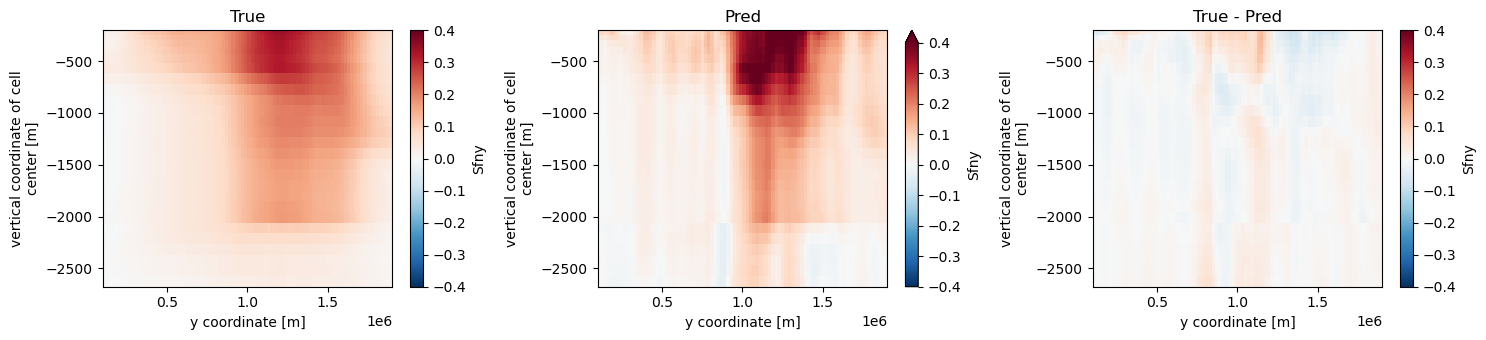

In [30]:
plt.figure(figsize=(15, 3.5))
           
plt.subplot(131)
ML_data_full.ML_dataset_norm.Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('True')

plt.subplot(132)
ds_pred.Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('Pred')

plt.subplot(133)
(ML_data_full.ML_dataset_norm-ds_pred).Sfny.mean(['time', 'XC']).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.title('True - Pred')


plt.tight_layout()

#plt.savefig('figures/'+Lsel+'km'+'/zonal_avg'+'_'+str(bias)+'.png')

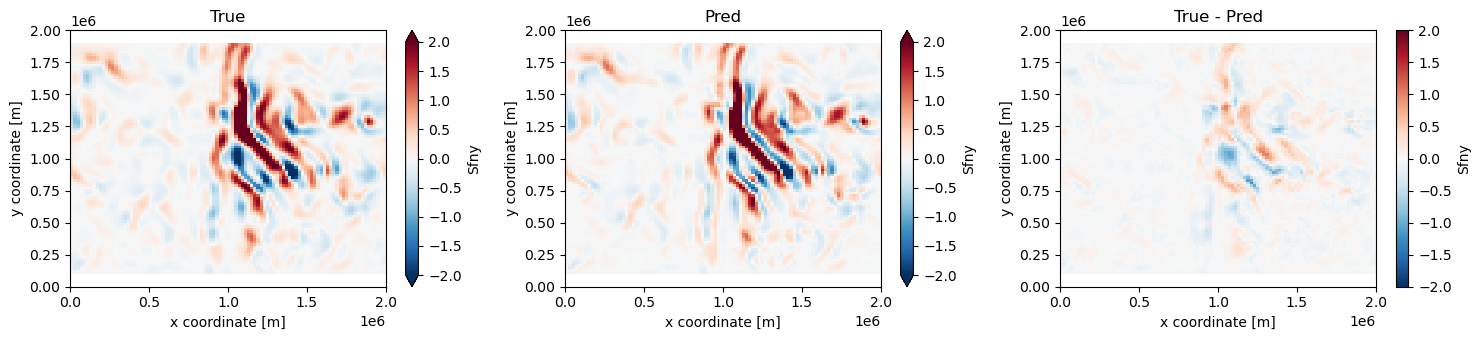

In [31]:
plt.figure(figsize=(15, 3.5))
zlev=-15
vlevs = 2.
plt.subplot(131)
ML_data_full.ML_dataset_norm.Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')
plt.ylim([0, 2e6])

plt.subplot(132)
ds_pred.Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('Pred')
plt.ylim([0, 2e6])

plt.subplot(133)
(ML_data_full.ML_dataset_norm-ds_pred).Sfny.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('True - Pred')
plt.ylim([0, 2e6])


plt.tight_layout()
#plt.savefig('figures/'+Lsel+'km'+'/XY_section'+'_'+str(bias)+'.png')

In [40]:
R2_XY = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','Z'])
R2_XZ = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','YC'])
R2_YZ = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','XC'])

R2_uT = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','Z','XC','YC'])
R2_vT = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfny', ['time','Z','XC','YC'])

R2_uT_z = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfnx', ['time','XC','YC'])
R2_vT_z = hf.R2(ds_test_full_no_edge, ds_pred, 'Sfny', ['time','XC','YC'])

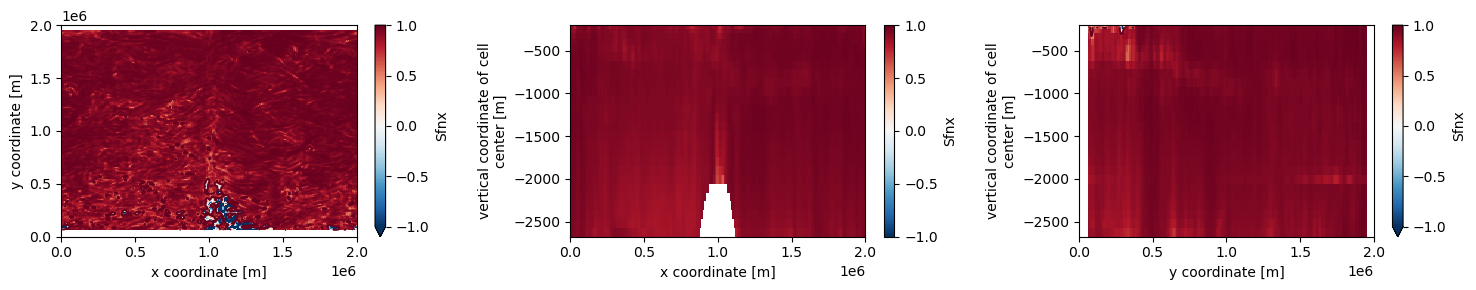

In [41]:
plt.figure(figsize=(15, 3))
           
vlim = 1.

plt.subplot(131)
R2_XY.plot(x='XC', vmin=-vlim)
R2_XY.plot.contour(levels=[0.5], x='XC', vmin=-vlim)

plt.subplot(132)
R2_XZ.plot(x='XC', vmin=-vlim)
R2_XZ.plot.contour(levels=[0.5], x='XC', vmin=-vlim)

plt.subplot(133)
R2_YZ.plot(x='YC', vmin=-vlim)
R2_YZ.plot.contour(levels=[0.5], x='YC', vmin=-vlim)

plt.tight_layout()

plt.savefig('figures/'+Lsel+'km'+'/R2_sections'+'_'+str(bias)+'.png')

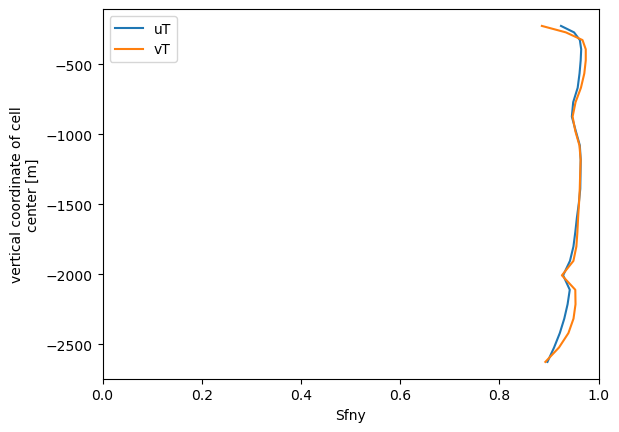

In [42]:
R2_uT_z.plot(y='Z', label='uT')
R2_vT_z.plot(y='Z', label='vT')
plt.xlim([0,1])
plt.legend()

plt.savefig('figures/'+Lsel+'km'+'/R2_profile.png')

## Fin